# Descrição de Características em Imagens

## 1) O que é “descrição de características” e onde entra no pipeline?

- **Definição:** A "descrição de características" (Feature Description) é uma estratégia para **representar (descrever) uma imagem ou parte dela de forma eficiente** e numérica.
- **No Pipeline:** Localiza-se no bloco de **Extração de Características**, logo após o pré-processamento (filtragem/segmentação) e antes do reconhecimento/interpretação.
- **Objetivo:** Transformar dados brutos (pixels) em vetores que permitam tarefas como **busca por similaridade**, **detecção de objetos**, ou **classificação** ("dado exemplos de uma classe, encontre similares").

## 2) Vetor de características (feature vector / descritor)

Um descritor é um **vetor numérico** (array N-dimensional) que simplifica a imagem mantendo o que é relevante (cor, forma, textura, bordas).

### Propriedades desejáveis:
1.  **Discriminativo:** Deve diferenciar classes/objetos distintos (ex: maçã vs banana).
2.  **Comparável:** Deve permitir o cálculo de uma **métrica de distância** (similaridade) tal que vetores próximos representem objetos visualmente parecidos.

## 3) Global vs Local

- **Descritores Globais:** Representam a imagem inteira em um único vetor (ex: histograma de cores de toda a cena). São bons para busca de imagens similares em geral, mas falham se houver oclusão ou confusão de fundo.
- **Descritores Locais:** Descrevem regiões específicas ou "pontos de interesse" (ex: cantos, olhos, rodas). Normalmente, uma imagem é representada por um conjunto de vários descritores locais.

## 4) Robustez e Invariância

O grande desafio é extrair o mesmo vetor numérico mesmo que a imagem sofra alterações:
- **Robustez:** Resistência a ruído, borrões, mudanças de iluminação e oclusões parciais.
- **Invariância:** O vetor não deve mudar drasticamente com **Rotação** e **Escala** (Zoom) do objeto.

## 5) Métricas de Distância

Para comparar dois vetores $u$ e $v$ de dimensão $N$, usamos a família de distâncias de Minkowski ($L_p$).

$$ D_p(u, v) = \left( \sum_{i=1}^{N} |u_i - v_i|^p \right)^{1/p} $$

- **L1 (Manhattan):** Soma das diferenças absolutas. $D_1 = \sum |u_i - v_i|$.
- **L2 (Euclidiana):** Distância geométrica padrão. $D_2 = \sqrt{\sum (u_i - v_i)^2}$.
- **L∞ (Chebyshev):** Diferença máxima em uma única dimensão. $D_\infty = \max(|u_i - v_i|)$.

> **Insight Prático:** A norma **L1** costuma ser mais robusta a *outliers* (valores extremos em uma dimensão) do que a L2, especialmente ao comparar histogramas.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import data

def lp_distance(u, v, p=2):
    u, v = np.array(u), np.array(v)
    diff = np.abs(u - v)
    if p == np.inf:
        return np.max(diff)
    if p == 1:
        return np.sum(diff)
    return np.sqrt(np.sum(diff**2))

# Exemplo rápido
vec_a = [10, 20, 30]
vec_b = [12, 18, 30]

print(f"Distância L1: {lp_distance(vec_a, vec_b, p=1)}")
print(f"Distância L2: {lp_distance(vec_a, vec_b, p=2):.2f}")

Distância L1: 4
Distância L2: 2.83


## 6) Abordagens Principais (Mapa Mental)

1.  **Pixels "crus":** Usar a própria imagem linearizada. Muito sensível e ineficiente.
2.  **Baseados em Cor:**
    - Distribuição (Histogramas).
    - **BIC (Border/Interior Classification):** Separa histograma de pixels de borda e de interior (captura forma grosseira).
3.  **Baseados em Forma:** Descritores de contorno, momentos de Hu, curvatura.
4.  **Baseados em Textura/Gradiente:**
    - Analisam a repetição de padrões ou a orientação das bordas (base do **HOG** e **SIFT**).
5.  **Aprendizado Profundo (Deep Learning):**
    - As **CNNs** aprendem a extrair os melhores descritores automaticamente durante o treino.

## 7) Mini-Demo: Extrair → Comparar → Ranquear

Vamos criar um sistema de busca simples.

### 7.1 Criando um Dataset "Toy"
Usaremos algumas imagens padrão e geraremos variações (rotação, ruído) para testar robustez.

Total de imagens no dataset: 12


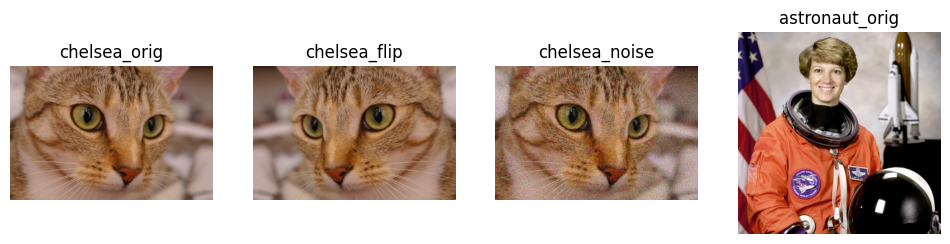

In [2]:
# Dataset Base
base_images = {
    'chelsea': data.chelsea(),           # Gato
    'astronaut': data.astronaut(),       # Humano
    'camera': cv2.cvtColor(data.camera(), cv2.COLOR_GRAY2RGB), # Objeto (gray->rgb para padronizar)
    'coffee': data.coffee()              # Objetos
}

dataset = []
labels = []

def add_to_dataset(img, label_name):
    dataset.append(img)
    labels.append(label_name)

for name, img in base_images.items():
    # 1. Original
    add_to_dataset(img, f"{name}_orig")
    
    # 2. Rotação (Flip)
    flip = cv2.flip(img, 1)
    add_to_dataset(flip, f"{name}_flip")
    
    # 3. Ruído Gaussiano
    noisy = img.astype(float) + np.random.normal(0, 20, img.shape)
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    add_to_dataset(noisy, f"{name}_noise")

print(f"Total de imagens no dataset: {len(dataset)}")

# Exibir algumas
def show_grid_mini(imgs, titles):
    fig, ax = plt.subplots(1, len(imgs), figsize=(12,3))
    for a, i, t in zip(ax, imgs, titles):
        a.imshow(i); a.set_title(t); a.axis('off')
    plt.show()

show_grid_mini(dataset[:4], labels[:4])

### 7.2 Extrator de Características (Descritor Global)
Usaremos um **Histograma de Cor HSV**. Já vimos que cor é poderosa, mas sensível a iluminação.

**Normalização:** Dividir o vetor pela soma total (L1) ou raiz da soma dos quadrados (L2) é essencial para que imagens de tamanhos diferentes (ou brilhos diferentes) possam ser comparadas.

In [3]:
def extract_features(img, bins=(8, 8, 8)):
    # 1. Converter para HSV (separa cor da intensidade)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # 2. Calcular Histograma 3D
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    
    # 3. Normalizar (L1 Norm) -> Transforma contagem absoluta em distribuição de probabilidade
    # Isso torna o descritor invariante ao número total de pixels (Scale Invariance parcial)
    cv2.normalize(hist, hist, alpha=1.0, norm_type=cv2.NORM_L1)
    
    # 4. Flatten para virar um vetor 1D
    return hist.flatten()

# Extrair para todo o dataset
features_db = [extract_features(img) for img in dataset]

### 7.3 Ranking (Query)
Escolhemos uma imagem (ex: gato com ruído) e buscamos as mais similares.

Query: chelsea_noise
Resultados:


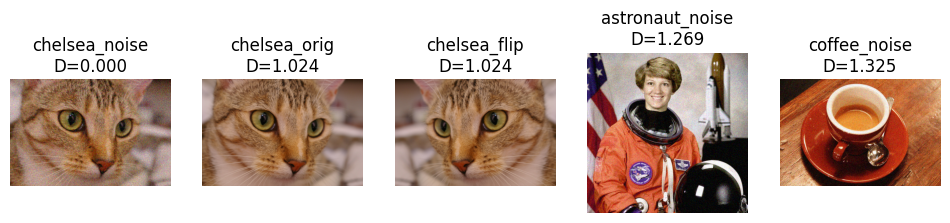

In [4]:
query_idx = 2  # 'chelsea_noise' (Gato com ruído)
query_feat = features_db[query_idx]

# Calcular distâncias para todo o dataset
dists = []
for i, feat in enumerate(features_db):
    d = lp_distance(query_feat, feat, p=1) # Usando Manhattan (L1)
    dists.append((d, i))

# Ordenar (menor distância = mais similar)
dists.sort(key=lambda x: x[0])

# Mostrar Top 5
top_imgs = []
top_titles = []
print(f"Query: {labels[query_idx]}")
print("Resultados:")
for d, idx in dists[:5]:
    top_imgs.append(dataset[idx])
    top_titles.append(f"{labels[idx]}\nD={d:.3f}")

show_grid_mini(top_imgs, top_titles)

## 8) Observações Finais

- O Histograma de Cor funcionou bem para rotação e ruído porque é um **descritor global** e estatístico (não importa onde o pixel está, só sua cor).
- Porém, ele falharia se a imagem fosse convertida para tons de cinza ou se a iluminação mudasse drasticamente.
- Descritores locais geram muitos vetores por imagem, exigindo métodos para combiná-los (Bag of Words) ou compará-los individualmente.

**Próximas Aulas:** Veremos como descrever **Bordas e Formas** e como criar descritores locais robustos.

## 9) Exercícios
1.  **L1 vs L2:** Tente trocar `p=1` por `p=2` na função `lp_distance`. O ranking muda? Os valores das distâncias mudam?
2.  **Invariância:** O que acontece se virarmos a imagem de cabeça para baixo (`cv2.flip(img, 0)`)? O histograma deve permanecer idêntico (distância ~ 0). Teste isso.
3.  **Sem Normalização:** Remova a linha `cv2.normalize` e tente comparar a imagem original com uma versão redimensionada (`cv2.resize`). O que acontece com a distância?